In [59]:
import chess.pgn

FILENAME = "lichess_db_standard_rated_2014-10.pgn"

# # Open your PGN file
# with open(file_name, "r") as pgn_file:
#     while True:
#         game = chess.pgn.read_game(pgn_file)
#         if game is None:
#             break  # End of file

#         board = game.board()
#         for move in game.mainline_moves():
#             print(board.fen())
#             print("Move:", board.san(move))
#             board.push(move)

with open(FILENAME) as pgn_file:
    first_game = chess.pgn.read_game(pgn_file)

board = first_game.board()

for move in first_game.mainline_moves():
    print(board.san(move))  # Print move in algebraic notation
    board.push(move)

d4
e6
c4
d5
Nc3
dxc4
e4
c6
Bxc4
Nf6
e5
Nd5
Nxd5
cxd5
Bb3
a6
f4
Nc6
Nf3
b5
Be3
Bb7
O-O
Na5
Bc2
Nc4
Bc1
Be7
Qd3
O-O
Qxh7#


In [6]:
print(board)

r . . q . r k .
. b . . b p p Q
p . . . p . . .
. p . p P . . .
. . n P . P . .
. . . . . N . .
P P B . . . P P
R . B . . R K .


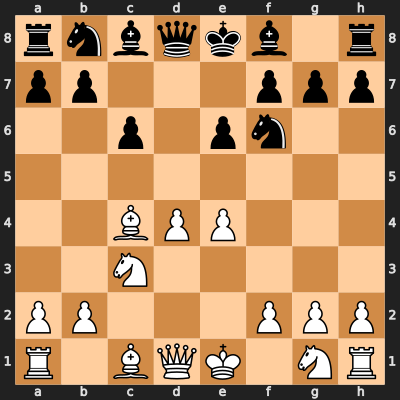

In [57]:
from IPython.display import SVG

# Show final position of the first game
SVG(chess.svg.board(board))
#resize the board to smaller size
SVG(chess.svg.board(board, size=400))

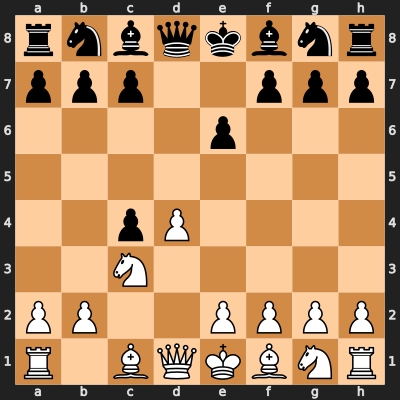

In [84]:
board = first_game.board()
for i, move in enumerate(first_game.mainline_moves()):
    board.push(move)
    if i == 5:
        break  # show board after 10 moves

SVG(chess.svg.board(board, size=400))

# Ratings Histogram

1000000it [00:01, 911575.34it/s]
Exception ignored in: <generator object pgn_text_game_generator at 0x130407de0>
Traceback (most recent call last):
  File "/var/folders/xb/0_m2vys15615hn4xqm0k1_7m0000gn/T/ipykernel_32495/2962771306.py", line 24, in <module>
RuntimeError: generator ignored GeneratorExit


Number of games with players rated above 2000: 66480
Number of games with players rated above 2200: 12700


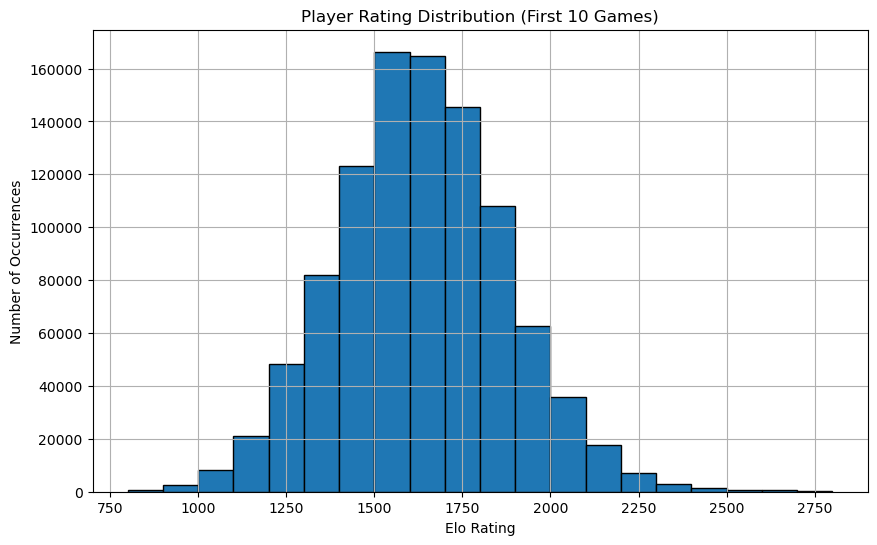

In [ ]:
def pgn_text_game_generator(file_path):
    with open(file_path) as f:
        game_lines = []
        for line in f:
            # only yield lines starting with [WhiteElo "..."] or [BlackElo "..."]

            if line.startswith("[WhiteElo") or line.startswith("[BlackElo"):
                try:
                # extract the rating from the line
                    rating = int(re.search(r'\d+', line).group())
                    yield rating
                
                except:
                    continue


# Example: Extract ratings without using python-chess
import re

ratings = []
RATED_ABOVE_2200 = 0
RATED_ABOVE_2000 = 0

for rating in tqdm(zip(pgn_text_game_generator(FILENAME), range(1000000))):
    if rating[0] >= 2000:
        RATED_ABOVE_2000 += 1
        if rating[0] >= 2200:
            RATED_ABOVE_2200 += 1

    ratings.append(rating[0])
    #print(rating[0])

print(f"Number of games with players rated above 2000: {RATED_ABOVE_2000}")
print(f"Number of games with players rated above 2200: {RATED_ABOVE_2200}")

# plot histogram of ratings

plt.figure(figsize=(10, 6))
plt.hist(ratings, bins=range(800, 2801, 100), edgecolor='black')
plt.title("Player Rating Distribution (First 10 Games)")
plt.xlabel("Elo Rating")
plt.ylabel("Number of Occurrences")
plt.grid(True)
plt.show()

In [93]:
import itertools
        
def pgn_text_game_generator2(file_path):
    with open(file_path) as f:
        game_lines = []
        for line in f:
            # only yield lines starting with [WhiteElo "..."] or [BlackElo "..."]
            if line.startswith("[Event"):
                yield line

def game_generator(file_path, n=None):
    if n is None:
        yield from pgn_text_game_generator2(file_path)
    else:
        yield from itertools.islice(pgn_text_game_generator2(file_path), n)

# count games

game_count = 0
for game in tqdm(game_generator(FILENAME)):
    game_count += 1

print(f"Number of games in the PGN file: {game_count}")

1111302it [00:01, 813326.22it/s]

Number of games in the PGN file: 1111302


# Creating position tensors

In [62]:
import torch
import chess
import chess.pgn

def piece_to_index(piece):
    """Map a chess.Piece to index 0–11 (or None for empty)."""
    if piece is None:
        return None
    offset = 0 if piece.color == chess.WHITE else 6
    return offset + piece.piece_type - 1  # piece_type in 1..6

def board_to_tensor(board):
    tensor = torch.zeros(8, 8, 18)  # (rows, cols, channels)

    # Piece planes (12)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        idx = piece_to_index(piece)
        if idx is not None:
            row, col = divmod(square, 8)
            tensor[row, col, idx] = 1

    # Side to move (1)
    stm_channel = 12
    if board.turn == chess.WHITE:
        tensor[:, :, stm_channel] = 1  # broadcast over all squares

    # # Castling rights (4)
    # castling_rights = {
    #     chess.WHITE: [chess.KING_SIDE, chess.QUEEN_SIDE],
    #     chess.BLACK: [chess.KING_SIDE, chess.QUEEN_SIDE],
    # }
    # castling_channels = [13, 14, 15, 16]
    # for i, (color, sides) in enumerate(castling_rights.items()):
    #     for j, side in enumerate(sides):
    #         if board.has_castling_rights(color) and board.has_kingside_castling_rights(color) if side == chess.KING_SIDE else board.has_queenside_castling_rights(color):
    #             tensor[:, :, castling_channels[2*i + j]] = 1

    # Castling rights (4)
    castling_channels = [13, 14, 15, 16]
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor[:, :, castling_channels[0]] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor[:, :, castling_channels[1]] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor[:, :, castling_channels[2]] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor[:, :, castling_channels[3]] = 1

    # En passant square (1)
    ep_channel = 17
    ep_square = board.ep_square
    if ep_square is not None:
        row, col = divmod(ep_square, 8)
        tensor[row, col, ep_channel] = 1

    return tensor

def game_to_tensor_sequence(game):
    """Returns a tensor of shape (m, 8, 8, 18) for a single game."""
    board = game.board()
    positions = []
    for move in game.mainline_moves():
        board.push(move)
        tensor = board_to_tensor(board)
        positions.append(tensor)
    return torch.stack(positions)  # (m, 8, 8, 18)

In [78]:
X = game_to_tensor_sequence(first_game)
print(X.shape)
X[0, :, :, 11]  # side to move

torch.Size([31, 8, 8, 18])


tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.]])

In [9]:
# import ChessTransformer
# read config from engine_config.yaml
import yaml
from src.engine import ChessTransformer

with open("engine_config.yaml", "r") as f:
    config = yaml.safe_load(f)


for key, value in config["model"].items():
    print(key, ":", value)

engine = ChessTransformer(config["model"])

embed_dim : 128
num_heads : 8
dropout : 0.1
mlp_ratio : 4
eval_hidden_dim : 128
num_layers : 12


In [10]:
# number of parameters in engine
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters in the model: {count_parameters(engine):,}")

Number of parameters in the model: 3,199,617


In [124]:
model = engine.blocks[0]

# count parameters in model

print(f"Number of parameters in the first transformer block: {count_parameters(model):,}")


Number of parameters in the first transformer block: 461,568


In [6]:
from chessengine.loss_heads import InCheckLoss
import torch

B = 4  # batch size
x = torch.randn(B, 65, 20)  # random input tensor
king_square = torch.randint(0, 64, (B,1))  # random king squares
in_check = torch.randint(0, 2, (B,1))  # random in-check flags

print(f'{in_check.dtype = }')

config = {"embed_dim": 20}

loss_fn = InCheckLoss(config)
loss1, loss2 = loss_fn(x, king_square, in_check.float())
print(loss1)
print(loss2)  

# board_x = x[:, 1:, :]  # Remove the [EVAL] token — shape becomes (B, 64, H)
# print(f'{board_x.shape=}')

# index = king_square.unsqueeze(-1).expand(-1, -1, board_x.size(-1))  # (B, 1, H)
# print(f'{index.shape=}')

# king_repr = board_x.gather(dim=1, index=index)  # (B, 1, H)
# print(f'{king_repr.shape=}')

in_check.dtype = torch.int64
tensor(0.6789, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor([[ 0.0934],
        [ 0.0061],
        [-0.1649],
        [-0.1257]], grad_fn=<SqueezeBackward1>)


In [17]:
from chessengine.dataclass import ChessPositionDataset

data = ChessPositionDataset(["../chess_engine/data/positions_short3.pt"])

In [18]:
len(data)

4346

In [20]:
N = 4346 
T = 16 # seconds

games = 1000000
positions = games * 100

time = T * positions / N
time_m = time / 60  # convert to minutes
time_h = time / 3600  # convert to hours
print(f"Time to train on {positions} positions: {time:.2f} seconds")
print(f"Time to train on {positions} positions: {time_m:.2f} minutes")
print(f"Time to train on {positions} positions: {time_h:.2f} hours")

Time to train on 100000000 positions: 368154.62 seconds
Time to train on 100000000 positions: 6135.91 minutes
Time to train on 100000000 positions: 102.27 hours


# NEW DATABASE - ABOVE 2400 RATINGS

In [33]:
def print_first_games(pgn_path, n_games=3):
    with open(pgn_path, "r", encoding="utf-8") as f:
        game_lines = []
        count = 0
        for line in f:
            if line.startswith("[Event "):
                if game_lines:
                    print("".join(game_lines))
                    print("=" * 80)
                    count += 1
                    if count >= n_games:
                        break
                game_lines = [line]
            else:
                game_lines.append(line)

# Example usage:
print_first_games("filtered_2400.pgn", n_games=3)

[Event "Rated Bullet game"]
[Site "https://lichess.org/OQPdf60o"]
[Date "2025.02.01"]
[Round "-"]
[White "PSti"]
[Black "arturogonzalez"]
[Result "0-1"]
[UTCDate "2025.02.01"]
[UTCTime "00:00:05"]
[WhiteElo "2462"]
[BlackElo "2416"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+6"]
[BlackTitle "CM"]
[ECO "A10"]
[Opening "English Opening"]
[TimeControl "60+0"]
[Termination "Normal"]

1. c4 { [%clk 0:01:00] } 1... d6 { [%clk 0:01:00] } 2. g3 { [%clk 0:01:00] } 2... Nf6 { [%clk 0:01:00] } 3. Bg2 { [%clk 0:01:00] } 3... g6 { [%clk 0:00:59] } 4. Nf3 { [%clk 0:00:59] } 4... Bg7 { [%clk 0:00:59] } 5. Nc3 { [%clk 0:00:59] } 5... O-O { [%clk 0:00:59] } 6. O-O { [%clk 0:00:58] } 6... c6 { [%clk 0:00:59] } 7. d4 { [%clk 0:00:58] } 7... d5 { [%clk 0:00:58] } 8. cxd5 { [%clk 0:00:57] } 8... cxd5 { [%clk 0:00:58] } 9. Ne5 { [%clk 0:00:56] } 9... Nc6 { [%clk 0:00:55] } 10. Nxc6 { [%clk 0:00:55] } 10... bxc6 { [%clk 0:00:55] } 11. Bg5 { [%clk 0:00:55] } 11... Bf5 { [%clk 0:00:54] } 12. Na4 { [%clk 0:00:54

## Games with evaluation

In [31]:
def check_if_eval_exists(pgn_path, max_games=None):
    with open(pgn_path, "r", encoding="utf-8") as f:
        game_lines = []
        total_games = 0
        count = 0
        for line in f:
            if line.startswith("[Event "):
                total_games += 1
                if game_lines:
                    game = "".join(game_lines)
                    if "%eval" in game:
                        count += 1
                    if max_games and total_games >= max_games:
                        break
                    game_lines = []
            else:
                game_lines.append(line)

    # Print the number of games with eval
    print(f"Total games: {total_games}")
    print(f"Games with eval: {count}")

# Example usage:
check_if_eval_exists("filtered_2400.pgn", max_games=None)

Total games: 1737008
Games with eval: 203480


## Time conrol 

In [2]:
def check_time_control(pgn_path, max_games=None):
    time_control = {}
    with open(pgn_path, "r", encoding="utf-8") as f:
        game_lines = []
        total_games = 0
        for line in f:
            if max_games and total_games == max_games:
                break
            if line.startswith("[Event "):
                total_games += 1
                #print(total_games)
            if line.startswith("[TimeControl"):
                # input in the format [TimeControl "300"] extract the "300"
                time_control_value = line.split('"')[1]
                # print(line)
                # print(time_control_value)
                time_control[time_control_value] = time_control.get(time_control_value, 0) + 1
                
    return total_games, time_control
    

total_games, time_control = check_time_control("filtered_2400.pgn", max_games=None)

# Print the number of games with eval
print(f"Total games: {total_games}")
print(f"Time control: {time_control}")

Total games: 1737008
Time control: {'60+0': 1295320, '180+2': 57054, '30+0': 65688, '180+0': 234866, '1800+2': 92, '600+0': 10122, '60+1': 21098, '120+1': 19134, '480+0': 619, '300+1': 438, '900+1': 97, '0+1': 5689, '1200+7': 1, '180+1': 2459, '900+2': 25, '45+0': 202, '600+1': 998, '1800+1': 286, '45+1': 18, '1200+8': 393, '900+10': 70, '300+5': 913, '60+3': 276, '60+2': 1310, '300+0': 4530, '600+3': 321, '0+2': 426, '1500+1': 86, '180+15': 20, '900+3': 127, '900+4': 1, '600+2': 568, '900+15': 44, '120+0': 881, '600+5': 577, '3600+2': 17, '1200+3': 2, '1500+0': 92, '120+10': 31, '900+5': 122, '300+10': 38, '900+0': 66, '600+10': 79, '30+1': 1066, '180+10': 52, '0+4': 267, '300+4': 66, '1320+2': 1, '300+3': 470, '120+15': 30, '360+2': 6, '60+15': 16, '1800+0': 169, '-': 503, '30+2': 188, '90+2': 150, '420+0': 59, '15+1': 653, '720+3': 27, '300+2': 201, '30+10': 10, '90+0': 995, '15+0': 4407, '180+3': 220, '1020+5': 6, '45+5': 12, '60+5': 81, '60+10': 46, '30+3': 93, '30+5': 16, '180+5'

In [13]:
import pandas as pd


time_control_filtered = {k: v for k, v in time_control.items() if int(v) >= 300 and k != '-'}
print(f"Time control filtered:") 
print(time_control_filtered)
time_control_df = pd.DataFrame(time_control_filtered.items(), columns=["TimeControl", "Count"])
time_control_df = time_control_df[time_control_df["Count"] >= 300]
# reorde by count
time_control_df = time_control_df.sort_values(by="Count", ascending=False)
print(time_control_df)

# TimeControl is given in the form "300+0" or "60+1" etc. The +1 is increment time. 
# Remove increment time from the TimeControl and sum all the game time. 
# E.g. "60+0" and "60+1" should be counted as 60 and added together.

# Create a new column with the time in seconds
time_control_df["TimeControl"] = time_control_df["TimeControl"].str.split("+").str[0].astype(int)
# add together equal time controls
time_control_df = time_control_df.groupby("TimeControl").sum().reset_index()
# sort by time control
time_control_df = time_control_df.sort_values(by="TimeControl", ascending=True)
time_control_df

Time control filtered:
{'60+0': 1295320, '180+2': 57054, '30+0': 65688, '180+0': 234866, '600+0': 10122, '60+1': 21098, '120+1': 19134, '480+0': 619, '300+1': 438, '0+1': 5689, '180+1': 2459, '600+1': 998, '1200+8': 393, '300+5': 913, '60+2': 1310, '300+0': 4530, '600+3': 321, '0+2': 426, '600+2': 568, '120+0': 881, '600+5': 577, '30+1': 1066, '300+3': 470, '15+1': 653, '90+0': 995, '15+0': 4407}
   TimeControl    Count
0         60+0  1295320
3        180+0   234866
2         30+0    65688
1        180+2    57054
5         60+1    21098
6        120+1    19134
4        600+0    10122
9          0+1     5689
15       300+0     4530
25        15+0     4407
10       180+1     2459
14        60+2     1310
21        30+1     1066
11       600+1      998
24        90+0      995
13       300+5      913
19       120+0      881
23        15+1      653
7        480+0      619
20       600+5      577
18       600+2      568
22       300+3      470
8        300+1      438
17         0+2      426


,TimeControl,Count
0,0,6115
1,15,5060
2,30,66754
3,60,1317728
4,90,995
5,120,20015
6,180,294379
7,300,6351
8,480,619
9,600,12586


In [ ]:
# convert time_control_df to a dictionary
time_control_dict = time_control_df.set_index("TimeControl").to_dict()["Count"]

time_control_dict

{0: 6115,
 15: 5060,
 30: 66754,
 60: 1317728,
 90: 995,
 120: 20015,
 180: 294379,
 300: 6351,
 480: 619,
 600: 12586,
 1200: 393}

In [12]:
%run preprocessing/pgn_time_filtering.py --input filtered_2400.pgn --output filtered_elo2400_time180.pgn --min_time 180

Filtering PGN file: filtered_2400.pgn
Output file: filtered_elo2400_time180.pgn
Minimum time: 180
Maximum games: None
Found 1737008 games in the PGN file


Filtering games: 100%|██████████| 1737008/1737008 [00:13<00:00, 133031.04it/s]


Saved 317083 filtered games to filtered_elo2400_time180.pgn


In [19]:
import json

def check_if_eval_exists(pgn_path, max_games=None):
    with open(pgn_path, "r", encoding="utf-8") as f:
        game_lines = []
        total_games = 0
        count = 0
        for line in f:
            obj = json.loads(line)
            pgn = obj["pgn"]
            total_games += 1
            if "%eval" in pgn:
                count += 1
            if max_games and total_games >= max_games:
                break
           
           
    return total_games, count
    

# Example usage:
total_games, count = check_if_eval_exists("filtered_elo2400_time180.pgn", max_games=None)

# Print the number of games with eval
print(f"Total games: {total_games}")
print(f"Games with eval: {count}")

Total games: 317083
Games with eval: 144896


# Creat Small test data

In [12]:
# take the first 100 lines from the file data/shards300_small/positions0.pgn
file_path = "data/shards300_small/shard_0.pgn"
with open(file_path, "r", encoding="utf-8") as f:
    lines = []
    for i, line in enumerate(f):
        if i < 100:
            lines.append(line)
        else:
            break

    with open("data/test_shard.pgn", "w", encoding="utf-8") as f_out:
        f_out.writelines(lines)


# Create Data Shards

In [2]:
def create_pgn_shards(pgn_path, out_path, games_per_shard=5000):
    with open(pgn_path, "r", encoding="utf-8") as f:
        shard = []
        shard_idx = 0
        for line in f:
            shard.append(line)
            if len(shard) == games_per_shard:
                with open(f"{out_path}/shard_{shard_idx}.pgn", "w", encoding="utf-8") as out_f:
                    out_f.writelines(shard)
                shard = []
                shard_idx += 1

        if shard:
            with open(f"{out_path}/shard_{shard_idx}.pgn", "w", encoding="utf-8") as out_f:
                out_f.writelines(shard)
    print(f"Created {shard_idx + 1} shards.")
# Example usage:
create_pgn_shards("filtered_elo2400_time300.pgn", "data/shards300_small", games_per_shard=1000)
        

Created 23 shards.


# Generate Positions

In [ ]:
%run chessengine/preprocessing/position_parsing.py --input data/shards300_small/shard_10.pgn --output data/shards300_small/positions10.pt

Parsing games: 1000it [01:01, 16.24it/s]


Saved 97604 positions to data/shards300_small/positions9.pt


In [15]:
import subprocess

for i in range(20, 23):  # or whatever range you want
    input_file = f"data/shards300_small/shard_{i}.pgn"
    output_file = f"data/shards300_small/positions{i}.pt"
    command = [
        "python3", "chessengine/preprocessing/position_parsing.py",
        "--input", input_file,
        "--output", output_file
    ]
    print(f"Parsing shard {i}...")
    subprocess.run(command)

Parsing shard 20...


Parsing games: 1000it [01:10, 14.27it/s]


Saved 113889 positions to data/shards300_small/positions20.pt
Parsing shard 21...


Parsing games: 1000it [01:11, 14.05it/s]


Saved 117169 positions to data/shards300_small/positions21.pt
Parsing shard 22...


Parsing games: 596it [00:40, 14.56it/s]


Saved 65961 positions to data/shards300_small/positions22.pt


In [13]:
%run preprocessing/position_parsing.py --input data/test_shard.pgn --output data/test_positions.pt

Parsing games: 100it [00:06, 14.95it/s]


Saved 11643 positions to data/test_positions.pt


In [9]:
from chessengine.dataclass import ChessPositionDataset
from chessengine.sampler import ShardSampler
from chessengine.dataloader import get_dataloaders
dataset = ChessPositionDataset(["data/test_positions.pt"])
sampler = ShardSampler(dataset,shuffle_shards=True, shuffle_within_shard=True) 
    
x, labels = dataset[0]
print(f"{x.shape = }")

[DEBUG] Loading sample 0 from shard 0, local idx 0
x.shape = torch.Size([8, 8, 21])


In [11]:
labels.keys()
labels["legal_moves"].shape
print(dir(dataset))
labels["true_index"]




['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', 'data_paths', 'format_item', 'index_map', 'shard_sizes']


tensor([1])

In [1]:
from chessengine.dataloader import get_dataloaders
# get config from engine_config.yaml
import yaml

with open("engine_config.yaml", "r") as f:
    config = yaml.safe_load(f)

config["data"]["batch_size"] = 2
config["data"]["num_workers"] = 0
config["data"]["persistent_workers"] = False
# get dataloaders
train_loader, val_loader = get_dataloaders(["data/test_positions.pt"], config["data"])

Loading dataset from: ['data/test_positions.pt']


/Users/itamarshamir/Documents/code/chess_engine/chessengine/dataclass.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location='cpu')


Train set size: 10479
Validation set size: 1164
Batch size: 2
Preparing sampler...
Preparing dataloaders with 0 workers...


In [1]:
from chessengine.loss_heads import InCheckLoss
import torch
import yaml 

# load config from engine_config.yaml
with open("engine_config.yaml", "r") as f:
    config = yaml.safe_load(f)


incheckloss = InCheckLoss(config)

# create random input tensor
B = 64  # batch size
H = 128
for i in range(1):
    x = torch.randn(B, 65, 128)  # random input tensor
    king_square = torch.randint(0, 64, (B,1))  # random king squares
    in_check = torch.randint(0, 2, (B,1))  # random in-check flags
    for j in range(4):
        b = torch.randint(0, B, (1,))  # random in-check flags
        in_check[b, :] = -100
    # print(in_check[:, 0])

    loss1, logits = incheckloss(x, king_square, in_check.float())
#     if loss1 <= 0:
#         print(f"loss1: {loss1}")
#         print(f"loss2: {logits[b, :]}")
#         print(f"b: {b}")
#         print(f"king_square: {king_square[b, :]}")
#         print(f"true_index: {in_check[b, :]}")
#         # print(in_check[b, :])
# # print(loss2)


loss:
tensor([  0.6985,   0.7032,   0.6299,   0.6134,   0.7216,   0.7586,   0.6158,
          0.7114,   0.7562,   0.8501,   0.5666,   0.4758,   0.5975,   0.6392,
          0.5399,   0.8829,   0.7161,   0.8262,   0.9177,   0.5820,   0.9049,
          0.6670, -22.4928,   0.7626,   0.6634,   0.6103,   0.6933,  -2.8919,
          0.6614,   0.8940,   0.8519,   0.6377,   0.8027,   0.6334,   0.7591,
          0.7685,   0.8218,   0.5390,   0.6493,   0.6855,   0.7375,   0.6517,
          0.6989,   0.6190,   0.7582,   0.6638,   0.6948,   0.6977,   0.7915,
          0.7678,   0.5948,   0.6811,   0.6612,  39.9800,   0.7262,   0.9077,
          0.5258,   0.5869,   0.9353,   0.7642,   0.6843,  -3.3443,   0.6531,
          0.7118], grad_fn=<ViewBackward0>)
idx where loss is < 0:
tensor([22, 27, 61])
valid:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [6]:
valid = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
loss = torch.tensor([ 0.6063,  0.8020,  0.7869,  0.8826,  0.6821,  0.5616,  0.6359,  0.7321,
         0.7419,  0.7735,  0.7202,  0.8155,  0.6611,  0.6697,  0.5940,  0.7786,
         0.7346,  0.6806,  0.9149,  0.6604,  0.7277,  0.6209,  0.7749,  0.6936,
         0.8489,  0.6533,  0.6617,  0.6670,  0.8272,  0.6780,  0.6676,  0.8489,
         0.8049,  0.5238,  0.6306,  0.8472,  0.8062, -3.6994,  0.6763,  0.6425,
         0.7070,  0.6805,  0.6883,  0.7389,  0.5516,  0.7131,  0.7508,  0.6462,
         0.7405,  0.7288,  0.7849,  1.0000,  0.6032,  0.6954,  0.7975,  0.6664,
         0.6174,  0.7213,  0.5672,  0.7089,  0.7973,  0.8160,  0.6465,  0.6873])
print(loss.shape)
valid.shape

torch.Size([64])


torch.Size([64])

In [29]:
import importlib
import chessengine.datamodule
importlib.reload(chessengine.datamodule)
from chessengine.datamodule import ChessDataModule
import yaml

# load config from engine_config.yaml
with open("engine_config.yaml", "r") as f:
    config = yaml.safe_load(f)

paths = ["data/test_positions.pt"]
datamodule = ChessDataModule(config, paths)

In [31]:
datamodule.setup()
data_loader = datamodule.train_dataloader()
for batch in data_loader:
    x, labels = batch
    print(f"{x.shape = }")
    print(f"{labels['legal_moves'].shape = }")
    print(f"{labels['true_index'].shape = }")
    break

/Users/itamarshamir/Documents/code/chess_engine/chessengine/dataclass.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


Train set size: 10479
Validation set size: 1164
x.shape = torch.Size([64, 8, 8, 21])
labels['legal_moves'].shape = torch.Size([64, 64, 49])
labels['true_index'].shape = torch.Size([64])


In [9]:
!python learning_rate_finder.py

{'seed': 42, 'data_split': 0.01, 'dataloader': {'batch_size': 4, 'num_workers': 0, 'persistent_workers': False}, 'model': {'feature_dim': 21, 'embed_dim': 128, 'num_heads': 8, 'dropout': 0.0, 'mlp_ratio': 4, 'eval_hidden_dim': 128, 'num_layers': 12, 'n_recycles': 4}, 'loss': {'eval_loss_weight': 0.0, 'move_loss_weight': 1, 'threat_loss_weight': 0.2, 'incheck_loss_weight': 0.1, 'use_move_weight': False}, 'train': {'lr': 0.0001, 'weight_decay': 0.01, 'T_max': 2, 'max_epochs': 30, 'device': 'mps', 'accelerator': 'mps'}}
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/itamarshamir/miniconda3/envs/chess_engine_py311/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


{'seed': 42, 'data_split': 0.01, 'dataloader': {'batch_size': 64, 'num_workers': 0, 'persistent_workers': False}, 'model': {'feature_dim': 21, 'embed_dim': 128, 'num_heads': 8, 'dropout': 0.0, 'mlp_ratio': 4, 'eval_hidden_dim': 128, 'num_layers': 12, 'n_recycles': 4}, 'loss': {'eval_loss_weight': 0.0, 'move_loss_weight': 1, 'threat_loss_weight': 0.2, 'incheck_loss_weight': 0.1, 'use_move_weight': False}, 'train': {'lr': 0.0009, 'weight_decay': 0.01, 'T_max': 2, 'max_epochs': 30, 'device': 'mps', 'accelerator': 'mps'}}
Train set size: 11527
Validation set size: 116


Finding best initial lr:  97%|█████████▋| 97/100 [00:23<00:00,  4.22it/s]
LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at /Users/itamarshamir/Documents/code/chess_engine/.lr_find_c3bce657-47f2-4c3f-b2f7-b8a360666918.ckpt
Restored all states from the checkpoint at /Users/itamarshamir/Documents/code/chess_engine/.lr_find_c3bce657-47f2-4c3f-b2f7-b8a360666918.ckpt
/var/folders/xb/0_m2vys15615hn4xqm0k1_7m0000gn/T/ipykernel_52841/2585758123.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Suggested LR: 0.00478630092322638
0.00478630092322638


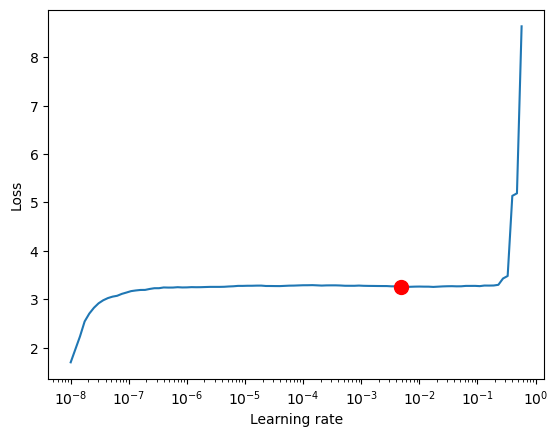

In [12]:
# %load learning_rate_finder.py
from chessengine.model.engine_pl import ChessLightningModule
from chessengine.model.datamodule import ChessDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.tuner import Tuner
import matplotlib.pyplot as plt
import yaml
import os
from dotenv import load_dotenv

load_dotenv()
TEST_DATASET = os.getenv("TEST_DATASET")


# load config from engine_config.yaml
with open("engine_config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Update config with mps settings
config['train']['accelerator'] = "mps"
config['dataloader']['num_workers'] = 0
config['dataloader']['persistent_workers'] = False

print(config)
data_paths = [TEST_DATASET]
dm = ChessDataModule(config, data_paths)
model = ChessLightningModule(config)

trainer = Trainer(accelerator="mps")
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, datamodule=dm)

# Plot suggestion
fig = lr_finder.plot(suggest=True)
fig.show()

# The new learning rate is updated in model.hparams.lr
print("Suggested LR:", model.hparams.lr)
print(lr_finder.suggestion())

# # Save best lr back to config
# config['train']['lr'] = lr_finder.suggestion()

In [16]:
!tar -cf positions_shards_10_22.tar data/shards300_small/positions{10..22}.pt

In [22]:
import os
from dotenv import load_dotenv
load_dotenv(".env")

training_paths = os.getenv("TRAINING_DATASET").split(", ")
training_paths

['/Users/itamarshamir/Documents/code/chess_engine/data/shards300_small/positions0.pt',
 '/Users/itamarshamir/Documents/code/chess_engine/data/shards300_small/positions1.pt']

# Distribution of number of legal moves

In [1]:
# torch load from data/shards300_small/positions10.pt

import torch
from chessengine.model.datamodule import ChessDataModule
test_path = "data/stacked_shards/positions10.pt"

config ={'dataloader': {"batch_size": 1, "num_workers": 0, "persistent_workers": False}, 'data_split':
    0.0, 'train': {'device': 'cpu'}
}
dm = ChessDataModule(config, [test_path], OVERFIT=False)
dm.setup()
loader = dm.train_dataloader()

/Users/itamarshamir/Documents/code/chess_engine/chessengine/model/dataclass.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  shard = torch.load(path, map_location="cpu")

Loaded data/stacked_shards/positions10.pt in 0.17s
Global max legal_moves width: 67
Train set size: 99426
Validation set size: 0


In [2]:
legal_moves_histogram = {}
print(loader)
# loop over the dataloader
for batch in loader:
    x, labels = batch
    legal_moves = labels["legal_moves"]
    l = labels["legal_moves"].shape[-1]
    
    legal_moves_histogram[l] = legal_moves_histogram.get(l, 0) + 1
    
print(legal_moves_histogram)

{13: 1138, 6: 1245, 10: 703, 22: 2218, 0: 235, 25: 2091, 35: 3471, 42: 2308, 21: 1727, 33: 3588, 38: 3288, 32: 3501, 18: 1548, 14: 1275, 11: 780, 19: 1659, 48: 720, 45: 1406, 23: 1887, 30: 3758, 39: 3075, 31: 3258, 2: 1337, 36: 3397, 28: 3049, 34: 3456, 26: 2325, 47: 999, 37: 3179, 15: 1442, 16: 1601, 3: 1667, 49: 607, 44: 1702, 24: 1741, 40: 2582, 4: 1711, 8: 674, 20: 3631, 5: 1585, 27: 2747, 12: 1048, 7: 794, 46: 1247, 41: 2399, 29: 3025, 9: 674, 1: 876, 43: 1977, 54: 123, 51: 328, 17: 1507, 52: 215, 50: 485, 57: 35, 53: 177, 55: 78, 58: 32, 60: 14, 56: 49, 59: 15, 67: 1, 63: 3, 64: 1, 61: 7, 62: 4, 65: 1}


## Histogram

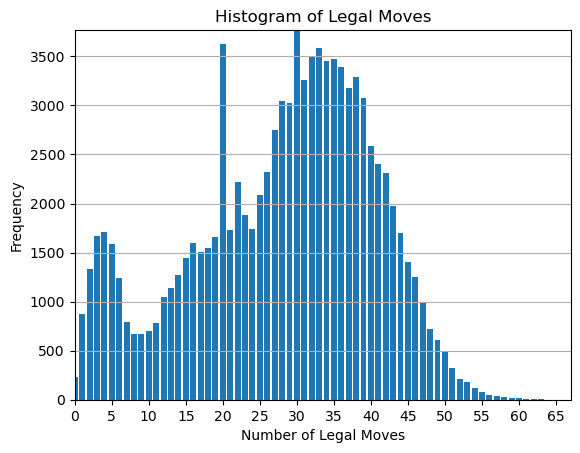

In [3]:
# create a histogram of legal moves
import matplotlib.pyplot as plt
import numpy as np


# Create a histogram of the legal moves
legal_moves_histogram = dict(sorted(legal_moves_histogram.items()))
keys = list(legal_moves_histogram.keys())
values = list(legal_moves_histogram.values())
plt.bar(keys, values)
plt.xlabel("Number of Legal Moves")
plt.ylabel("Frequency")
plt.title("Histogram of Legal Moves")
# only show x ticks in jumps of 5 so 0, 5, 10, 15, 20 etc
plt.xticks(np.arange(min(keys), max(keys)+1, 5))
plt.xlim(min(keys), max(keys))
plt.ylim(0, max(values) + 10)
#plt.xticks(np.arange(min(keys), max(keys)+1, 1))
plt.grid(axis='y')
plt.show()


## Max number of legal moves

In [4]:
# max legal moves
max_legal_moves = max(legal_moves_histogram.keys())
print(f"Max legal moves: {max_legal_moves}")

Max legal moves: 67


## Get some probabilities

In [5]:
total_moves = sum(legal_moves_histogram.values())
prob = {key: value / total_moves for key, value in legal_moves_histogram.items()}

# mean number of legal moves
mean_legal_moves = sum(key * value for key, value in prob.items())
print(f"Mean number of legal moves: {mean_legal_moves:.2f}")

# probability of below 10 legal moves
prob_below_10 = sum(prob[key] for key in prob if key <= 10)
print(f"Probability of below 10 legal moves: {prob_below_10:.2f}")

Mean number of legal moves: 28.00
Probability of below 10 legal moves: 0.12


## top5 and top3 probabilities 
i.e. mean probability of 5/3 moves out of all

In [18]:
mean_top5_fraction = sum(p * 5 / m for m, p in prob.items() if m > 4) + sum(p for m, p in prob.items() if m < 5)
mean_top5_fraction = 100 * mean_top5_fraction
mean_top3_fraction = sum(p * 3 / m for m, p in prob.items() if m > 2) + sum(p for m, p in prob.items() if m < 3)
mean_top3_fraction = 100 * mean_top3_fraction
mean_top1_fraction = sum(p * 1 / m for m, p in prob.items() if m > 0) + sum(p for m, p in prob.items() if m < 1)
mean_top1_fraction = 100 * mean_top1_fraction

print(f"Mean top 5 fraction: {mean_top5_fraction:.2f}%")
print(f"Mean top 3 fraction: {mean_top3_fraction:.2f}%")
print(f"Mean top 1 fraction: {mean_top1_fraction:.2f}%")

Mean top 5 fraction: 26.30%
Mean top 3 fraction: 17.69%
Mean top 1 fraction: 6.87%


In [1]:
# %load data/convert_to_stacked_shards.py
import torch
import os
from tqdm import tqdm

def convert_shard_format(input_path, output_path):
    os.makedirs(output_path, exist_ok=True)
    pt_files = sorted(f for f in os.listdir(input_path) if f.endswith(".pt"))

    for filename in tqdm(pt_files, desc="Converting shards"):
        print(filename)
        in_file = os.path.join(input_path, filename)
        out_file = os.path.join(output_path, filename)

        data = torch.load(in_file, map_location="cpu")

        keys = data[0].keys()
        batch = {key: [] for key in keys}

        # Collect values
        for sample in data:
            for key in keys:
                batch[key].append(sample[key])

        # Special handling for legal_moves
        legal_moves_list = batch['legal_moves']
        max_L = max(t.shape[1] for t in legal_moves_list)
        padded_legal_moves = []

        for t in legal_moves_list:
            L = t.shape[1]
            if L < max_L:
                pad = torch.full((64, max_L - L), fill_value=-100, dtype=t.dtype)
                t = torch.cat([t, pad], dim=1)
            padded_legal_moves.append(t)

        # Replace legal_moves with padded and stacked
        stacked = {}
        stacked['legal_moves'] = torch.stack(padded_legal_moves)

        # Stack all other fields
        for key in keys:
            if key == 'legal_moves':
                continue
            values = batch[key]
            if isinstance(values[0], torch.Tensor):
                stacked[key] = torch.stack(values)
            else:
                stacked[key] = torch.tensor(values)

        # Save
        torch.save(stacked, out_file)

    print(f"✅ Done! Converted shards saved to: {output_path}")

In [6]:
input_path = "/Users/itamarshamir/Documents/code/chess_engine/data/shards300_small"
output_path = "/Users/itamarshamir/Documents/code/chess_engine/data/stacked_shards"
convert_shard_format(input_path, output_path)

Converting shards:   0%|          | 0/23 [00:00<?, ?it/s]/var/folders/xb/0_m2vys15615hn4xqm0k1_7m0000gn/T/ipykernel_17582/1184053627.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

positions0.pt


Converting shards:   4%|▍         | 1/23 [00:15<05:41, 15.52s/it]

positions1.pt


Converting shards:   9%|▊         | 2/23 [00:31<05:35, 15.97s/it]

positions10.pt


Converting shards:  13%|█▎        | 3/23 [00:49<05:36, 16.83s/it]

positions11.pt


Converting shards:  17%|█▋        | 4/23 [01:09<05:42, 18.04s/it]

positions12.pt


Converting shards:  22%|██▏       | 5/23 [01:28<05:29, 18.33s/it]

positions13.pt


Converting shards:  26%|██▌       | 6/23 [01:48<05:19, 18.78s/it]

positions14.pt


Converting shards:  30%|███       | 7/23 [02:10<05:18, 19.89s/it]

positions15.pt


Converting shards:  35%|███▍      | 8/23 [02:31<05:03, 20.26s/it]

positions16.pt


Converting shards:  39%|███▉      | 9/23 [02:51<04:44, 20.29s/it]

positions17.pt


Converting shards:  43%|████▎     | 10/23 [03:09<04:13, 19.54s/it]

positions18.pt


Converting shards:  48%|████▊     | 11/23 [03:28<03:54, 19.50s/it]

positions19.pt


Converting shards:  52%|█████▏    | 12/23 [03:50<03:40, 20.02s/it]

positions2.pt


Converting shards:  57%|█████▋    | 13/23 [04:09<03:18, 19.89s/it]

positions20.pt


Converting shards:  61%|██████    | 14/23 [04:29<02:57, 19.71s/it]

positions21.pt


Converting shards:  65%|██████▌   | 15/23 [04:49<02:40, 20.08s/it]

positions22.pt


Converting shards:  70%|██████▉   | 16/23 [05:02<02:05, 17.91s/it]

positions3.pt


Converting shards:  74%|███████▍  | 17/23 [05:20<01:46, 17.71s/it]

positions4.pt


Converting shards:  78%|███████▊  | 18/23 [05:39<01:31, 18.37s/it]

positions5.pt


Converting shards:  83%|████████▎ | 19/23 [05:58<01:14, 18.52s/it]

positions6.pt


Converting shards:  87%|████████▋ | 20/23 [06:18<00:56, 18.89s/it]

positions7.pt


Converting shards:  91%|█████████▏| 21/23 [06:36<00:36, 18.47s/it]

positions8.pt


Converting shards:  96%|█████████▌| 22/23 [06:54<00:18, 18.54s/it]

positions9.pt


Converting shards: 100%|██████████| 23/23 [07:11<00:00, 18.77s/it]


✅ Done! Converted shards saved to: /Users/itamarshamir/Documents/code/chess_engine/data/stacked_shards


In [9]:
pt_files = sorted(f for f in os.listdir(output_path) if f.endswith(".pt"))
for file in pt_files:
    print(file)
    data = torch.load(os.path.join(output_path, file), map_location="cpu")
    for k,v in data.items():
        print(f"{k}: {v.shape}")

positions0.pt
legal_moves: torch.Size([106862, 64, 66])
board: torch.Size([106862, 8, 8, 21])
eval: torch.Size([106862, 1])
move_target: torch.Size([106862, 64])
king_square: torch.Size([106862, 1])
check: torch.Size([106862, 1])
threat_target: torch.Size([106862, 64])
terminal_flag: torch.Size([106862, 1])
true_index: torch.Size([106862, 1])
positions1.pt


/var/folders/xb/0_m2vys15615hn4xqm0k1_7m0000gn/T/ipykernel_17582/2446006796.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(output_path, f

legal_moves: torch.Size([97178, 64, 67])
board: torch.Size([97178, 8, 8, 21])
eval: torch.Size([97178, 1])
move_target: torch.Size([97178, 64])
king_square: torch.Size([97178, 1])
check: torch.Size([97178, 1])
threat_target: torch.Size([97178, 64])
terminal_flag: torch.Size([97178, 1])
true_index: torch.Size([97178, 1])
positions10.pt
legal_moves: torch.Size([99426, 64, 67])
board: torch.Size([99426, 8, 8, 21])
eval: torch.Size([99426, 1])
move_target: torch.Size([99426, 64])
king_square: torch.Size([99426, 1])
check: torch.Size([99426, 1])
threat_target: torch.Size([99426, 64])
terminal_flag: torch.Size([99426, 1])
true_index: torch.Size([99426, 1])
positions11.pt
legal_moves: torch.Size([106628, 64, 65])
board: torch.Size([106628, 8, 8, 21])
eval: torch.Size([106628, 1])
move_target: torch.Size([106628, 64])
king_square: torch.Size([106628, 1])
check: torch.Size([106628, 1])
threat_target: torch.Size([106628, 64])
terminal_flag: torch.Size([106628, 1])
true_index: torch.Size([106628,

In [11]:
!tar -cf positions_shards_12_22.tar data/stacked_shards/positions{12..22}.pt

In [1]:
from chessengine.model.dataclass import ChessPositionDataset
from dotenv import load_dotenv
import os
load_dotenv()
TEST_DATASET = os.getenv("TEST_DATASET")
print(TEST_DATASET)

dataset = ChessPositionDataset([TEST_DATASET])


/Users/itamarshamir/Documents/code/chess_engine/data/test_positions.pt
Loaded /Users/itamarshamir/Documents/code/chess_engine/data/test_positions.pt in 0.02s
Global max legal_moves width: 61


/Users/itamarshamir/Documents/code/chess_engine/chessengine/model/dataclass.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  shard = torch.load(path, map_location="cpu")

In [6]:
print(len(dataset))

for i, data in enumerate(dataset):
    x, labels = data
    print(f"{labels['legal_moves'].shape = }")
    
    if i > 10:
        break



11643
labels['legal_moves'].shape = torch.Size([64, 61])
labels['legal_moves'].shape = torch.Size([64, 61])
labels['legal_moves'].shape = torch.Size([64, 61])
labels['legal_moves'].shape = torch.Size([64, 61])
labels['legal_moves'].shape = torch.Size([64, 61])
labels['legal_moves'].shape = torch.Size([64, 61])
labels['legal_moves'].shape = torch.Size([64, 61])
labels['legal_moves'].shape = torch.Size([64, 61])
labels['legal_moves'].shape = torch.Size([64, 61])
labels['legal_moves'].shape = torch.Size([64, 61])
labels['legal_moves'].shape = torch.Size([64, 61])
labels['legal_moves'].shape = torch.Size([64, 61])


In [ ]:
from chessengine.model.datamodule import ChessDataModule
import torch
import yaml
# load config from engine_config.yaml
with open("engine_config.yaml", "r") as f:
    config = yaml.safe_load(f)
config['dataloader']['num_workers'] = 0
config['dataloader']['persistent_workers'] = False
config['dataloader']['batch_size'] = 64
config['train']['device'] = 'cpu'

data_paths = [TEST_DATASET]
dm = ChessDataModule(config, data_paths)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

j = torch.randint(0, len(train_loader.dataset)//64, (1,))
print(f"Random index: {j}")
for i, batch in enumerate(train_loader):
    if i == j:
        x, labels = batch
        print(f"{x.shape = }")
        for k, v in labels.items():
            print(f"{k}: {v.shape}")
        break

Loaded /Users/itamarshamir/Documents/code/chess_engine/data/test_positions.pt in 0.01s
Global max legal_moves width: 61
Train set size: 10479
Validation set size: 1164
Random index: tensor([87])
x.shape = torch.Size([64, 8, 8, 21])
eval: torch.Size([64, 1])
check: torch.Size([64, 1])
king_square: torch.Size([64, 1])
threat_target: torch.Size([64, 64])
terminal_flag: torch.Size([64, 1])
legal_moves: torch.Size([64, 64, 48])
true_index: torch.Size([64, 1])


In [25]:
from chessengine.model.engine_pl import ChessLightningModule
import yaml
# load config from engine_config.yaml
with open("engine_config.yaml", "r") as f:
    config = yaml.safe_load(f)

config['dataloader']['num_workers'] = 0
config['dataloader']['persistent_workers'] = False
config['model']['embed_dim'] = 256
config['model']['eval_hidden_dim'] = 256
config['model']['num_heads'] = 16

model = ChessLightningModule(config)

# number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {count_parameters(model):,}")

Number of parameters in the model: 13,057,803


In [31]:
l = [1,2,3,4,5]

l[1:]

[2, 3, 4, 5]